In [1]:
# Part of the code was taken from here: https://vowpalwabbit.org/tutorials/cb_simulation.html

In [2]:
from vowpalwabbit import pyvw
import random
import matplotlib.pyplot as plt
import numpy as np

In [3]:
# This function modifies (context, action, cost, probability) to VW friendly format
def to_vw_example_format(context, actions, cb_label = None):
    if cb_label is not None:
        chosen_action, cost, prob = cb_label
    example_string = ""
    example_string += "shared |User user={} time_of_day={}\n".format(context["user"], context["time_of_day"])
    for action in actions:
        if cb_label is not None and action == chosen_action:
            example_string += "0:{}:{} ".format(cost, prob)
        example_string += "|Action article={} \n".format(action)
    #Strip the last newline
    return example_string[:-1]

In [4]:
# Sample from a distribution
def sample_custom_pmf(pmf):
    total = sum(pmf)
    scale = 1 / total
    pmf = [x * scale for x in pmf]
    draw = random.random()
    sum_prob = 0.0
    for index, prob in enumerate(pmf):
        sum_prob += prob
        if(sum_prob > draw):
            return index, prob

In [5]:
# get an action, given a model, context and actions
def get_action(vw, context, actions):
    vw_text_example = to_vw_example_format(context,actions)
    pmf = vw.predict(vw_text_example)
    chosen_action_index, prob = sample_custom_pmf(pmf)
    return actions[chosen_action_index], prob

In [6]:
# RL environment: 
users = ['Tom', 'Anna']
times_of_day = ['morning', 'afternoon']
actions = ["politics", "sports", "music", "food", "finance", "health", "camping"]

def choose_user(users):
    return random.choice(users)

def choose_time_of_day(times_of_day):
    return random.choice(times_of_day)

In [26]:
# Scenario 2: Preferences change over time
# We introduce two more reward functions along with the two introduced in
# the tutorial for contextual bandits. We then change the reward functions
# after every 1250 iterations. 

In [8]:
context = {"user":"Tom","time_of_day":"morning"}
actions = ["politics", "sports", "music", "food"]

# Reward functions: 
# VW tries to minimize loss/cost, therefore we will pass cost as -reward
USER_LIKED_ARTICLE = -1.0
USER_DISLIKED_ARTICLE = 0.0

# given context and action, this function returns the cost/ negative reward
def get_cost(context,action):
    if context['user'] == "Tom":
        if context['time_of_day'] == "morning" and action == 'politics':
            return USER_LIKED_ARTICLE
        elif context['time_of_day'] == "afternoon" and action == 'music':
            return USER_LIKED_ARTICLE
        else:
            return USER_DISLIKED_ARTICLE
    elif context['user'] == "Anna":
        if context['time_of_day'] == "morning" and action == 'sports':
            return USER_LIKED_ARTICLE
        elif context['time_of_day'] == "afternoon" and action == 'politics':
            return USER_LIKED_ARTICLE
        else:
            return USER_DISLIKED_ARTICLE
        
def get_cost_new1(context,action):
    if context['user'] == "Tom":
        if context['time_of_day'] == "morning" and action == 'politics':
            return USER_LIKED_ARTICLE
        elif context['time_of_day'] == "afternoon" and action == 'sports':
            return USER_LIKED_ARTICLE
        else:
            return USER_DISLIKED_ARTICLE
    elif context['user'] == "Anna":
        if context['time_of_day'] == "morning" and action == 'sports':
            return USER_LIKED_ARTICLE
        elif context['time_of_day'] == "afternoon" and action == 'sports':
            return USER_LIKED_ARTICLE
        else:
            return USER_DISLIKED_ARTICLE

def get_cost_new2(context,action):
    if context['user'] == "Tom":
        if context['time_of_day'] == "morning" and action == 'music':
            return USER_LIKED_ARTICLE
        elif context['time_of_day'] == "afternoon" and action == 'politics':
            return USER_LIKED_ARTICLE
        else:
            return USER_DISLIKED_ARTICLE
    elif context['user'] == "Anna":
        if context['time_of_day'] == "morning" and action == 'food':
            return USER_LIKED_ARTICLE
        elif context['time_of_day'] == "afternoon" and action == 'music':
            return USER_LIKED_ARTICLE
        else:
            return USER_DISLIKED_ARTICLE
        
def get_cost_new3(context,action):
    if context['user'] == "Tom":
        if context['time_of_day'] == "morning" and action == 'music':
            return USER_LIKED_ARTICLE
        elif context['time_of_day'] == "afternoon" and action == 'politics':
            return USER_LIKED_ARTICLE
        else:
            return USER_DISLIKED_ARTICLE
    elif context['user'] == "Anna":
        if context['time_of_day'] == "morning" and action == 'music':
            return USER_LIKED_ARTICLE
        elif context['time_of_day'] == "afternoon" and action == 'politics':
            return USER_LIKED_ARTICLE
        else:
            return USER_DISLIKED_ARTICLE

In [27]:
def get_cost_function1(iteration, total_iterations):
    if iteration > total_iterations/2:
        return get_cost_new1
    else:
        return get_cost

# change reward function after every quarter of total iterations  
# If total iterations = 5000,  we change the reward function
# after 1250 iterations. 
def get_cost_function2(iteration, total_iterations):
    if iteration > total_iterations/4 and iteration < total_iterations/2:
        return get_cost_new1, 0.7
    elif iteration > total_iterations/2 and iteration < 3 * total_iterations/4:
        return get_cost_new2, 0.7
    elif iteration > 3 * total_iterations/4:
        return get_cost_new3, 0.5, 
    else:
        return get_cost, 0.3

In [10]:
def run_simulation(vw, num_iterations, users, times_of_day, actions, get_cost_function, use_noise=False, do_learn = True):
    cost_sum = 0.
    ctr = []

    for i in range(1, num_iterations+1):
        # 1. In each simulation choose a user
        user = choose_user(users)
        # 2. Choose time of day for a given user
        time_of_day = choose_time_of_day(times_of_day)

        # 3. Pass context to vw to get an action
        context = {'user': user, 'time_of_day': time_of_day}
        action, prob = get_action(vw, context, actions)

        # 4. Get cost of the action we chose
        cost_function, noise_std = get_cost_function(i, num_iterations)
        cost = cost_function(context, action)
        if use_noise:
            cost = cost + np.random.normal(0, noise_std)
        cost_sum += cost

        if do_learn:
            # 5. Inform VW of what happened so we can learn from it
            vw_format = vw.parse(to_vw_example_format(context, actions, (action, cost, prob)),pyvw.vw.lContextualBandit)
            # 6. Learn
            vw.learn(vw_format)
            # 7. Let VW know you're done with these objects
            vw.finish_example(vw_format)

        # We negate this so that on the plot instead of minimizing cost, we are maximizing reward
        ctr.append(-1*cost_sum/i)

    return ctr

In [28]:
# We first run different exploration algorithms and then select the best
# runs of these algorithms against each other. Each run is averaged over 
# 10 different seed values. 

In [11]:
# Explore first: 
exp_first_algos = ["--cb_explore_adf -q UA --quiet --first 100",
                  "--cb_explore_adf -q UA --quiet --first 1000",
                  "--cb_explore_adf -q UA --quiet --first 2000"]

# Epsilon-greedy: 
ep_greed_algos = ["--cb_explore_adf -q UA --quiet --epsilon 0.1",
                 "--cb_explore_adf -q UA --quiet --epsilon 0.2",
                 "--cb_explore_adf -q UA --quiet --epsilon 0.3"]

# Bagging explorer:
bag_exp_algos = ["--cb_explore_adf -q UA --quiet --bag 5",
                "--cb_explore_adf -q UA --quiet --bag 10",
                "--cb_explore_adf -q UA --quiet --bag 15"]

# Softmax explorer
soft_exp_algos = ["--cb_explore_adf -q UA --quiet --softmax --lambda 10",
                 "--cb_explore_adf -q UA --quiet --softmax --lambda 100",
                 "--cb_explore_adf -q UA --quiet --softmax --lambda 200"]

# RND explorer
rnd_exp_algos = ["--cb_explore_adf -q UA --quiet --rnd 3 --epsilon 0.025",
                "--cb_explore_adf -q UA --quiet --rnd 3 --epsilon 0.05",
                "--cb_explore_adf -q UA --quiet --rnd 3 --epsilon 0.075"]

all_algos = [exp_first_algos, 
             ep_greed_algos, 
             bag_exp_algos, 
             soft_exp_algos, 
             rnd_exp_algos
            ]

In [13]:
total_iterations = 5000
seeds = [121, 321, 431, 652, 781, 900, 1, 0, 15, 22]
all_algo_list = []
for algo in all_algos:
    algo_list = []
    for algo_hyp in algo:
        algo_hyp_list = []
        for seed in seeds:
            random.seed(seed)
            
            vw = pyvw.vw(algo_hyp)
            ctr = run_simulation(vw, total_iterations, 
                                 users, times_of_day, actions, 
                                 get_cost_function2)
            algo_hyp_list.append(ctr)
    
        algo_list.append(algo_hyp_list)
    all_algo_list.append(algo_list)

In [14]:
import seaborn as sns

colors = sns.color_palette('hls')
font_scale = 1.5
sns.set(style="darkgrid")
plt.rcParams.update({'font.size': 32})
fontsize = 16
labelsize=13
title_font = 15

In [ ]:
# Explore first deteriorates as the reward function changes. 

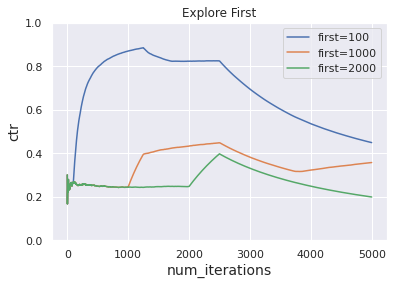

In [15]:
# Explore first: 

fig = plt.figure()
x = np.arange(5000)

explore_first = np.stack(all_algo_list[0])
y0 = np.mean(explore_first[0], axis=0)
yerr0 = np.std(explore_first[0], axis=0)

y1 = np.mean(explore_first[1], axis=0)
yerr2 = np.std(explore_first[1], axis=0)

y2 = np.mean(explore_first[2], axis=0)
yerr2 = np.std(explore_first[2], axis=0)

plt.plot(x, y0)
plt.plot(x, y1)
plt.plot(x, y2)

plt.xlabel('num_iterations', fontsize=14)
plt.ylabel('ctr', fontsize=14)
plt.ylim([0,1])
plt.title("Explore First")
plt.legend(['first=100', 'first=1000', 'first=2000'])

plt.show()

In [29]:
# Epsilon greedy adapts as the reward function changes. 

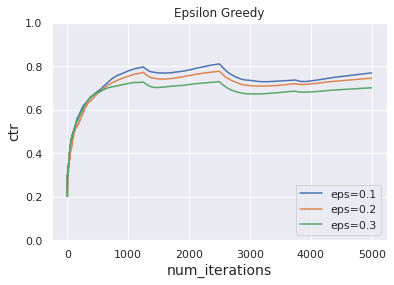

In [16]:
# eps greedy: 
fig = plt.figure()
x = np.arange(5000)

eps_greedy = np.stack(all_algo_list[1])
y0 = np.mean(eps_greedy[0], axis=0)
yerr0 = np.std(eps_greedy[0], axis=0)

y1 = np.mean(eps_greedy[1], axis=0)
yerr2 = np.std(eps_greedy[1], axis=0)

y2 = np.mean(eps_greedy[2], axis=0)
yerr2 = np.std(eps_greedy[2], axis=0)

plt.plot(x, y0)
plt.plot(x, y1)
plt.plot(x, y2)

plt.xlabel('num_iterations', fontsize=14)
plt.ylabel('ctr', fontsize=14)
plt.ylim([0,1])

plt.title("Epsilon Greedy")
plt.legend(['eps=0.1', 'eps=0.2', 'eps=0.3'])

plt.show()

In [30]:
# Bagging Explorer adapts for the first change, but is not able to adapt
# quick enough for the last change. It could be that it needs to run 
# longer. 

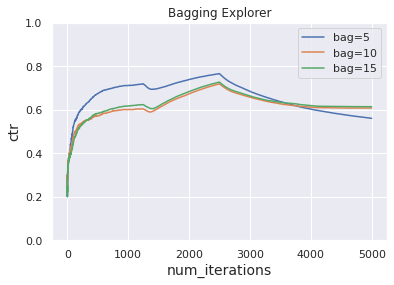

In [17]:
# Bag exp: 
fig = plt.figure()
x = np.arange(5000)

bag_exp = np.stack(all_algo_list[2])
y0 = np.mean(bag_exp[0], axis=0)
yerr0 = np.std(bag_exp[0], axis=0)

y1 = np.mean(bag_exp[1], axis=0)
yerr2 = np.std(bag_exp[1], axis=0)

y2 = np.mean(bag_exp[2], axis=0)
yerr2 = np.std(bag_exp[2], axis=0)

plt.plot(x, y0)
plt.plot(x, y1)
plt.plot(x, y2)

plt.xlabel('num_iterations', fontsize=14)
plt.ylabel('ctr', fontsize=14)
plt.ylim([0,1])

plt.title("Bagging Explorer")
plt.legend(['bag=5', 'bag=10', 'bag=15'])

plt.show()

In [31]:
# Softmax explorer shows similar performance to the bagging explorer. It could
# improve if run for longer period. 

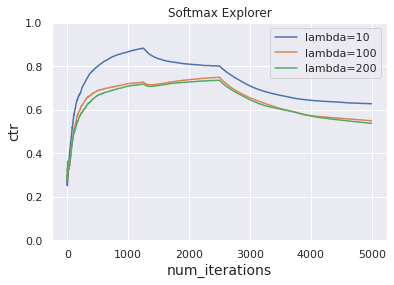

In [18]:
# soft exp: 
fig = plt.figure()
x = np.arange(5000)

soft_exp = np.stack(all_algo_list[3])
y0 = np.mean(soft_exp[0], axis=0)
yerr0 = np.std(soft_exp[0], axis=0)

y1 = np.mean(soft_exp[1], axis=0)
yerr2 = np.std(soft_exp[1], axis=0)

y2 = np.mean(soft_exp[2], axis=0)
yerr2 = np.std(soft_exp[2], axis=0)

plt.plot(x, y0)
plt.plot(x, y1)
plt.plot(x, y2)

plt.xlabel('num_iterations', fontsize=14)
plt.ylabel('ctr', fontsize=14)
plt.ylim([0,1])

plt.title("Softmax Explorer")
plt.legend(['lambda=10', 'lambda=100', 'lambda=200'])


plt.show()

In [32]:
# RND eadapts very quickly to the changes. 

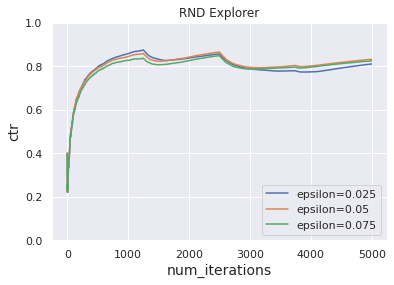

In [19]:
# RND exp: 
fig = plt.figure()
x = np.arange(5000)

rnd_exp = np.stack(all_algo_list[4])
y0 = np.mean(rnd_exp[0], axis=0)
yerr0 = np.std(rnd_exp[0], axis=0)

y1 = np.mean(rnd_exp[1], axis=0)
yerr2 = np.std(rnd_exp[1], axis=0)

y2 = np.mean(rnd_exp[2], axis=0)
yerr2 = np.std(rnd_exp[2], axis=0)

plt.plot(x, y0)
plt.plot(x, y1)
plt.plot(x, y2)

plt.xlabel('num_iterations', fontsize=14)
plt.ylabel('ctr', fontsize=14)
plt.ylim([0,1])

plt.title("RND Explorer")
plt.legend(['epsilon=0.025', 'epsilon=0.05', 'epsilon=0.075'])


plt.show()

In [33]:
# RND explorer showed the best performance of them all. 

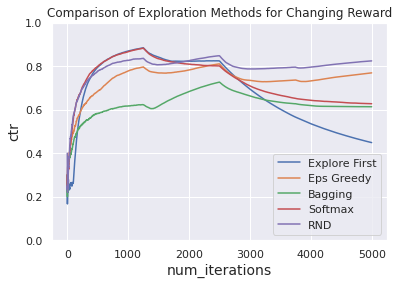

In [20]:
# We compare the setting of each algorithm. 

# RND exp: 
fig = plt.figure()
x = np.arange(5000)

y0 = np.mean(np.stack(all_algo_list[0])[0], axis=0)

y1 = np.mean(np.stack(all_algo_list[1])[0], axis=0)

y2 = np.mean(np.stack(all_algo_list[2])[2], axis=0)

y3 = np.mean(np.stack(all_algo_list[3])[0], axis=0)


y4 = np.mean(np.stack(all_algo_list[4])[2], axis=0)


plt.plot(x, y0)
plt.plot(x, y1)
plt.plot(x, y2)
plt.plot(x, y3)
plt.plot(x, y4)

plt.xlabel('num_iterations', fontsize=14)
plt.ylabel('ctr', fontsize=14)
plt.ylim([0,1])

plt.title("Comparison of Exploration Methods for Changing Reward")
plt.legend(['Explore First', 'Eps Greedy', 'Bagging', 'Softmax', 'RND'])


plt.show()

In [35]:
# Introducing noise to the reward redistribution. 
# We add normally distributed noise of standard deviation sigma and mean 0 
# to the previous reward function. And then perform similar experiments
# as before. The standard deviation sigma is changed during training. It
# starts with the value of 0.3 and then is increased to 0.5 and then to 0.7.
# It is 0.3 for first 1250 iterations, 0.5 for the next 1250 iterations and 
# 0.7 for the rest of the training. 

In [22]:
# Explore first: 
exp_first_algos = ["--cb_explore_adf -q UA --quiet --first 100",
                  "--cb_explore_adf -q UA --quiet --first 1000",
                  "--cb_explore_adf -q UA --quiet --first 2000"]

# Epsilon-greedy: 
ep_greed_algos = ["--cb_explore_adf -q UA --quiet --epsilon 0.1",
                 "--cb_explore_adf -q UA --quiet --epsilon 0.2",
                 "--cb_explore_adf -q UA --quiet --epsilon 0.3"]

# Bagging explorer:
bag_exp_algos = ["--cb_explore_adf -q UA --quiet --bag 5",
                "--cb_explore_adf -q UA --quiet --bag 10",
                "--cb_explore_adf -q UA --quiet --bag 15"]

# Softmax explorer
soft_exp_algos = ["--cb_explore_adf -q UA --quiet --softmax --lambda 10",
                 "--cb_explore_adf -q UA --quiet --softmax --lambda 100",
                 "--cb_explore_adf -q UA --quiet --softmax --lambda 200"]

# RND explorer
rnd_exp_algos = ["--cb_explore_adf -q UA --quiet --rnd 3 --epsilon 0.025",
                "--cb_explore_adf -q UA --quiet --rnd 3 --epsilon 0.05",
                "--cb_explore_adf -q UA --quiet --rnd 3 --epsilon 0.075"]

all_algos = [exp_first_algos, 
             ep_greed_algos, 
             bag_exp_algos, 
             soft_exp_algos, 
             rnd_exp_algos
            ]

In [24]:
total_iterations = 5000
seeds = [121, 321, 431, 652, 781, 900, 1, 0, 15, 22]
all_algo_list = []
for algo in all_algos:
    algo_list = []
    for algo_hyp in algo:
        algo_hyp_list = []
        for seed in seeds:
            random.seed(seed)
            
            vw = pyvw.vw(algo_hyp)
            ctr = run_simulation(vw, total_iterations, 
                                 users, times_of_day, actions, 
                                 get_cost_function2, use_noise=True)
            algo_hyp_list.append(ctr)
    
        algo_list.append(algo_hyp_list)
    all_algo_list.append(algo_list)

In [36]:
# Again RND performs the best among all the algorithms. But it's performance
# decreases as the noise standard deviation increases.

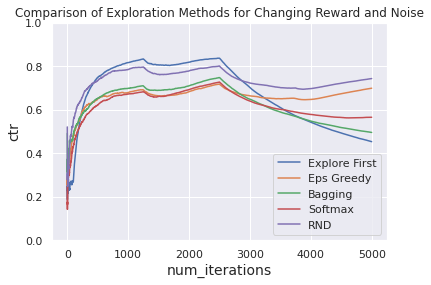

In [25]:
# We compare the setting of each algorithm. 

# RND exp: 
fig = plt.figure()
x = np.arange(5000)

y0 = np.mean(np.stack(all_algo_list[0])[0], axis=0)

y1 = np.mean(np.stack(all_algo_list[1])[0], axis=0)

y2 = np.mean(np.stack(all_algo_list[2])[2], axis=0)

y3 = np.mean(np.stack(all_algo_list[3])[0], axis=0)


y4 = np.mean(np.stack(all_algo_list[4])[2], axis=0)


plt.plot(x, y0)
plt.plot(x, y1)
plt.plot(x, y2)
plt.plot(x, y3)
plt.plot(x, y4)

plt.xlabel('num_iterations', fontsize=14)
plt.ylabel('ctr', fontsize=14)
plt.ylim([0,1])

plt.title("Comparison of Exploration Methods for Changing Reward and Noise")
plt.legend(['Explore First', 'Eps Greedy', 'Bagging', 'Softmax', 'RND'])


plt.show()